In [1]:
# Import modules and packages:
%pylab inline
import pandas as pd
import sys, ast, os
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
import pickle as pickle
import numpy as np
import time
import itertools
data_type = 'float32'

os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=' + data_type + ',force_device=True'
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/cell2location/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os
import cell2location.models as c2l
import anndata
import scanpy as sc

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text

Populating the interactive namespace from numpy and matplotlib


Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'In file included from /tmp/try_flags_23wezzoj.c:4:0:\n/usr/include/cudnn.h:63:10: fatal error: driver_types.h: No such file or directory\n #include "driver_types.h"\n          ^~~~~~~~~~~~~~~~\ncompilation terminated.\n'
Mapped name None to device cuda: Tesla V100-SXM2-32GB (0000:62:00.0)


In [2]:
# read a previously trained LocationModel
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_viseum_snrna/'
sp_results_folder = f'{results_folder}'
sc_results_folder = f'{results_folder}regression_model/'

run_name = 'CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k'

# path for saving figures
fig_path = f'{sp_results_folder}{run_name}/plots/figures/'
sc_figpath = sc.settings.figdir
sc.settings.figdir = f'{fig_path}'

sp_data_file = f'{sp_results_folder}{run_name}/sp_with_clusters.h5ad'
adata_vis = anndata.read(sp_data_file)
#adata_vis.obs['sample'] = list(adata_vis.uns['spatial'].keys())[0]

In [3]:
# annotate region clusters
region_annot = pd.read_csv(f'{sp_results_folder}{run_name}/20200904_regionAnnotation_copy.csv')
region_annot = region_annot.loc[~region_annot['region_04092020'].isna(),:]
region_annot.index = region_annot['region_04092020'].astype(int).astype(str)
region_annot['region_final'] = region_annot['region_final'].astype(int).astype(str)
region_annot.index.name = 'region_cluster'
region_annot = region_annot.reindex(index = list(adata_vis.obs['region_cluster']))
region_annot.index = adata_vis.obs_names

adata_vis.obs[region_annot.columns] = region_annot

In [4]:
# identify spot locations to crop near tissue
def get_crop_coord(slide):

    crop_max = (slide.obsm['spatial'] * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef']).max(axis=0)
    crop_min = (slide.obsm['spatial'] * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef']).min(axis=0)

    crop_x = [crop_min[0]-50, crop_max[0]+50]
    crop_y = [crop_min[1]-20, crop_max[1]+0]

    return crop_x, crop_y

def select_slide(adata, s, s_col='sample'):
    r""" Select data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial samples
    :param s: name of selected sample
    :param s_col: column in adata.obs listing sample name for each location
    """

    slide = adata_vis[adata_vis.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

In [5]:
# Define functions that compute per layer average abundance of each cell type & plot annotated scatterplot
def layer_distribution(slide, lay=None, layer_col='SSp_manual_layers', 
                       post_type='mean_spot_factors', 
                       summary_fun=np.mean, proportion_per_layer=False, 
                      layers=['L1', 'L23', 'L4', 'L5', 'L6']):
    
    sel_clust_col = [post_type in i for i in slide.obs.columns]
    sel_clust_col = slide.obs.columns[sel_clust_col]
    from re import sub # create nice names
    sel_clust = [sub(post_type, '', i) for i in sel_clust_col]

    # log-transform and save with nice names
    #slides[s].obs[sel_clust] = np.log10(slides[s].obs[sel_clust_col])
    infer_lay_df = slide.obs[sel_clust_col]
    infer_lay_df.columns = sel_clust

    infer_lay = pd.DataFrame(index=sel_clust)
    for r in slide.obs[layer_col].unique():
        ind = slide.obs[layer_col].isin([r])
        # sum / mean of cell density across all spots within a region
        infer_lay[r] = summary_fun(infer_lay_df.loc[ind, :], axis=0)
    
    infer_lay = infer_lay[layers]
    infer_lay.columns = layers
    infer_lay = infer_lay.loc[infer_lay.sum(1) > 0, :]
    if lay is not None:
        infer_lay = infer_lay.loc[lay.index, :]
    infer_lay = infer_lay.loc[np.sort(list(infer_lay.index)), :]
    
    # convert to proportions per layer
    if proportion_per_layer is True:
        infer_lay = infer_lay / infer_lay.sum(0)
    
    return infer_lay

def plot_hist2d(x, y, xlab, ylab, log=False, scatter_kwdargs:dict={}):
    
    corr = np.corrcoef(
        x.values.flatten(), 
        y.values.flatten())[0,1]
    corr_log10 = np.corrcoef(
        np.log10(x.values.flatten() + 1), 
        np.log10(y.values.flatten() + 1))[0,1]

    if log:
        x = np.log10(x.values.flatten() + 1)
        y = np.log10(y.values.flatten() + 1)
        
        xlab = xlab + ' (log10)'
        ylab = ylab + ' (log10)'
    else:
        x = x.values.flatten()
        y = y.values.flatten()

    #plt.hist2d(x, y, bins=35, norm=matplotlib.colors.LogNorm());
    plt.scatter(x, y, **scatter_kwdargs);
    plt.xlabel(xlab);
    plt.ylabel(ylab);
    plt.xlim(0);
    plt.ylim(0);
    plt.title(r'$R^2$: ' \
              + str(np.round(corr, 3))\
              #+ r', $R^2$ log: '+ str(np.round(corr_log10, 3))
             );

/nfs/team205/vk7/software/miniconda/envs/cellpymc/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
Trying to set attribute `.uns` of view, copying.
/nfs/team205/vk7/software/miniconda/envs/cellpymc/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'region_final' as categorical
... storing 'old_region' as categorical
... storing 'location' as categorical
... storing 'subregion' as categorical
... storing 'cortical_layer' as categorical
... storing 'region_label' as categorical
... storing 'comments' as categorical
... storing 'SSp_manual_layers' as categorical


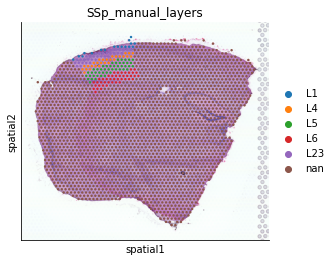

In [6]:
### load cortical layer annotations ###
# read in manual SSp cortical layer annotations
lay = pd.DataFrame()
for s in np.unique(adata_vis.obs['sample']):
    
    lay_file = results_folder + 'manual_SSp_layers/SSp_ManLayerAnn_' \
                + str(s) + '.csv'
    lay_ = pd.read_csv(lay_file, index_col='Barcode')
    lay_.index = [str(s) + '_' + i for i in lay_.index]
    lay = pd.concat([lay, lay_])
    
adata_vis.obs['SSp_manual_layers'] = lay.reindex(index=adata_vis.obs_names) 

# plot to check that it loaded correctly
slide = select_slide(adata_vis, 'ST8059051')
sc.pl.spatial(slide, img_key = "hires", cmap='magma',
              color=['SSp_manual_layers'], size=1,
              gene_symbols='SYMBOL', ncols=1)

Trying to set attribute `.uns` of view, copying.
/nfs/team205/vk7/software/miniconda/envs/cellpymc/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
Trying to set attribute `.uns` of view, copying.
/nfs/team205/vk7/software/miniconda/envs/cellpymc/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
Trying to set attribute `.uns` of view, copying.
/nfs/team205/vk7/software/miniconda/envs/cellpymc/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
Trying to set attribute `.uns` of view, copying.
/nfs/team205/vk7/software/miniconda/envs/cellpymc/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarni

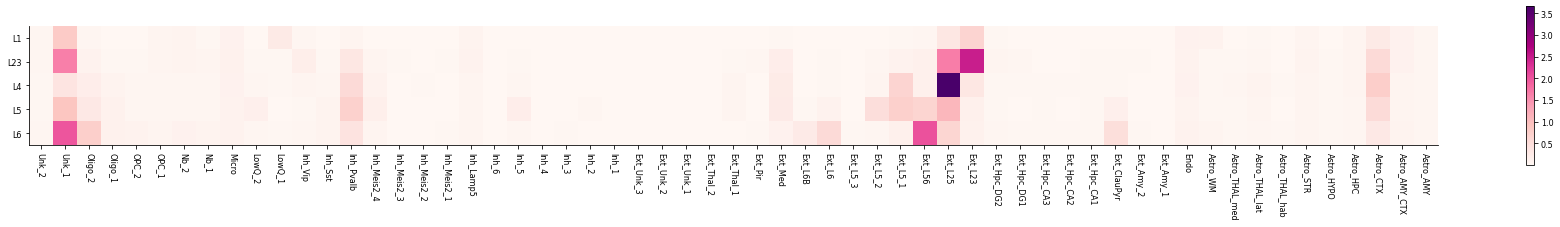

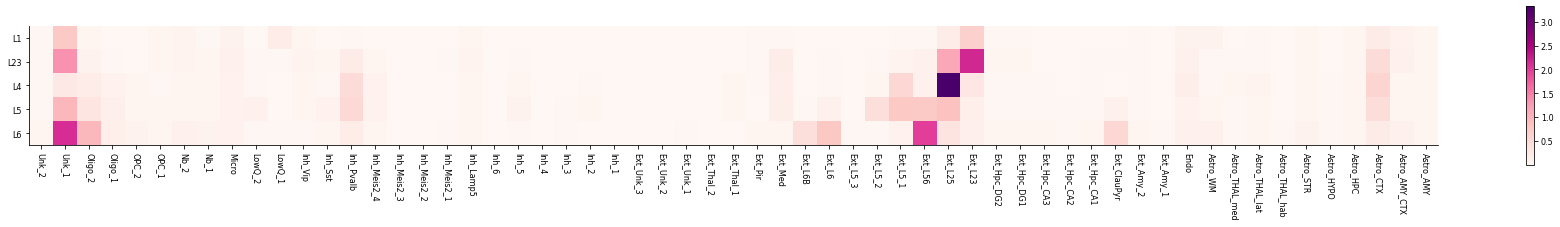

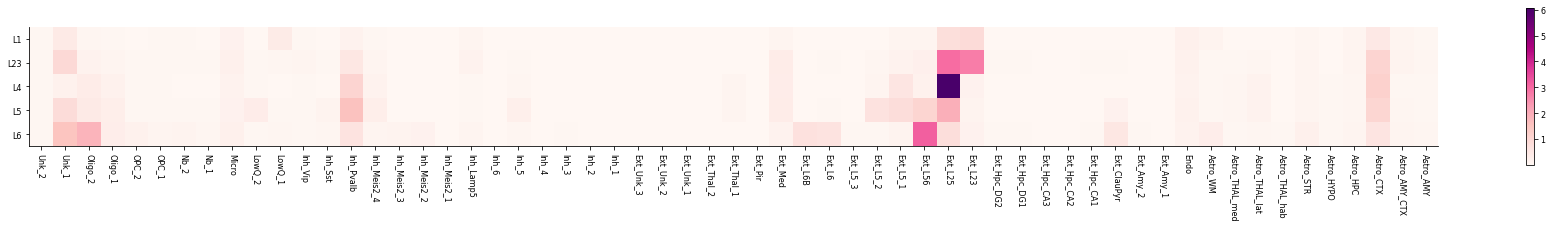

In [7]:
# Compute per layer abundances
infer_lay_ST8059048 = layer_distribution(select_slide(adata_vis, 'ST8059048').copy(), 
                                         summary_fun=np.mean, proportion_per_layer=False)
infer_lay_ST8059049 = layer_distribution(select_slide(adata_vis, 'ST8059049').copy(), 
                                         summary_fun=np.mean, proportion_per_layer=False)
infer_lay_ST8059051 = layer_distribution(select_slide(adata_vis, 'ST8059051').copy(), 
                                         summary_fun=np.mean, proportion_per_layer=False)
infer_lay_ST8059052 = layer_distribution(select_slide(adata_vis, 'ST8059052').copy(), 
                                         summary_fun=np.mean, proportion_per_layer=False)
infer_lay_ST8059050 = layer_distribution(select_slide(adata_vis, 'ST8059050').copy(), 
                                         summary_fun=np.mean, proportion_per_layer=False,
                                        layers=['L23', 'L4', 'L5', 'L6'])

# Plot per layer abundances of all cell types per section for supplementary materials
from cell2location.plt.plot_heatmap import clustermap
with matplotlib.rc_context({'axes.facecolor': 'white', 'font.size': 8}):
    clustermap(infer_lay_ST8059048.T, figure_size=(25, 3), 
               cmap='RdPu', log=False,
               cluster_rows=False, cluster_cols=False)
    plt.show()
    clustermap(infer_lay_ST8059049.T, figure_size=(25, 3), 
               cmap='RdPu', log=False,
               cluster_rows=False, cluster_cols=False)
    plt.show()
    clustermap(infer_lay_ST8059052.T, figure_size=(25, 3), 
               cmap='RdPu', log=False,
               cluster_rows=False, cluster_cols=False)
    plt.show()

In [8]:
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.size'] = 7
# matplotlib.rcParams['figure.figsize'] = (8, 6)
matplotlib.rcParams['savefig.dpi'] = 250

### Whole genes

In [9]:
samples = [infer_lay_ST8059051.T, infer_lay_ST8059049.T, infer_lay_ST8059048.T, infer_lay_ST8059052.T, infer_lay_ST8059050.T]
samples = [i.values.sum(axis=0)[:, np.newaxis] for i in samples]

sample_matrix = np.concatenate(samples, axis=1)
df = pd.DataFrame(sample_matrix, columns=['ST8059051', 'ST8059049', 'ST8059048', 'ST8059052', 'ST8059050'],
                  index=infer_lay_ST8059051.T.columns)

<Figure size 216x576 with 0 Axes>

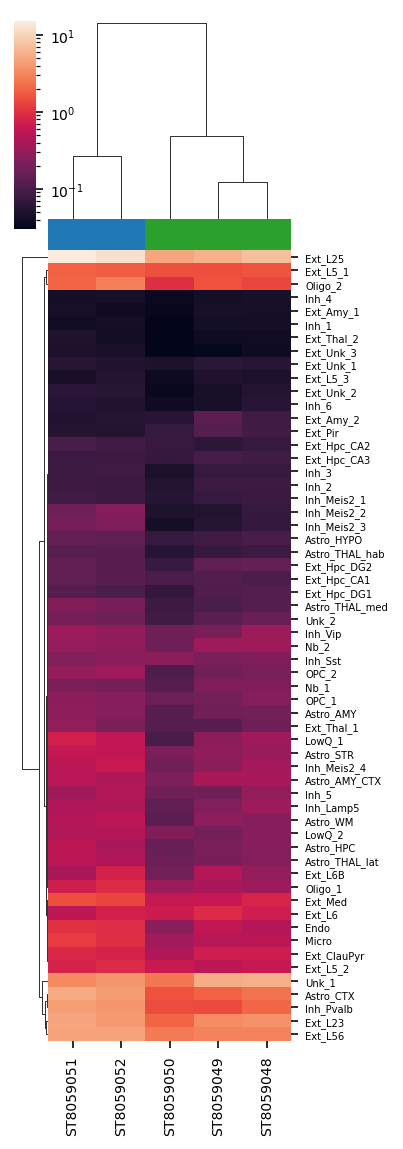

In [10]:
plt.figure(figsize=(3, 8))
col_colors = ['C0', 'C2', 'C2', 'C0', 'C2']
g = sns.clustermap(df, dendrogram_ratio=(.1, .2), col_colors=col_colors,
                   figsize=(3, 8), norm=matplotlib.colors.LogNorm())

g.ax_heatmap.set_yticks(np.arange(len(g.dendrogram_row.reordered_ind)) + 0.5)
g.ax_heatmap.set_yticklabels(infer_lay_ST8059051.T.columns[g.dendrogram_row.reordered_ind].values);
g.ax_heatmap.yaxis.set_tick_params(labelsize=5)

# plt.savefig('FigS8/FigS8_without_layers.pdf', bbox_inches='tight')

###  Layers - mice

In [11]:
samples = [infer_lay_ST8059051.T, infer_lay_ST8059049.T, infer_lay_ST8059048.T, infer_lay_ST8059052.T, infer_lay_ST8059050.T]

In [12]:
pd.concat(samples)

,Astro_AMY,Astro_AMY_CTX,Astro_CTX,Astro_HPC,Astro_HYPO,Astro_STR,Astro_THAL_hab,Astro_THAL_lat,Astro_THAL_med,Astro_WM,...,LowQ_2,Micro,Nb_1,Nb_2,OPC_1,OPC_2,Oligo_1,Oligo_2,Unk_1,Unk_2
L1,0.065608,0.167891,0.842369,0.197104,0.021415,0.143026,0.026442,0.047769,0.027463,0.266437,...,0.023764,0.333526,0.041348,0.104132,0.048054,0.014166,0.014546,0.055259,0.580570,0.037162
L23,0.069820,0.140484,1.418581,0.128018,0.029332,0.160820,0.023679,0.090394,0.046368,0.034391,...,0.040133,0.296275,0.037846,0.038755,0.049869,0.034318,0.087247,0.183224,0.466262,0.046199
L4,0.051986,0.062176,1.485977,0.080516,0.037459,0.101500,0.026549,0.184043,0.065906,0.035077,...,0.083445,0.174470,0.029872,0.032240,0.060493,0.075599,0.208678,0.357347,0.199230,0.036096
L5,0.047750,0.055671,1.008667,0.066640,0.036704,0.098366,0.025094,0.145821,0.057132,0.034902,...,0.273785,0.160587,0.033336,0.032739,0.057390,0.085904,0.178654,0.535575,0.518537,0.036434
L6,0.051022,0.103345,0.567650,0.072750,0.029242,0.124494,0.027082,0.060146,0.033014,0.100448,...,0.047412,0.221939,0.064908,0.110868,0.047669,0.096441,0.252248,0.854127,1.507368,0.040884
L1,0.039409,0.100244,0.210276,0.050062,0.009112,0.048368,0.009084,0.017245,0.008887,0.084381,...,0.006070,0.086239,0.027363,0.075230,0.032799,0.004442,0.005778,0.030772,0.745925,0.019757
L23,0.036858,0.106965,0.470115,0.039745,0.014945,0.051260,0.012813,0.026350,0.018096,0.026887,...,0.016184,0.120002,0.041088,0.070397,0.045333,0.008222,0.022992,0.082784,1.347485,0.025048
L4,0.032165,0.044387,0.585239,0.038458,0.022606,0.051204,0.014671,0.070083,0.029615,0.021439,...,0.026410,0.097748,0.035406,0.028569,0.025406,0.035501,0.093691,0.196891,0.262405,0.022013
L5,0.030646,0.053339,0.458756,0.035421,0.020084,0.050945,0.014783,0.060393,0.025406,0.030662,...,0.121720,0.100340,0.039170,0.050503,0.033990,0.043539,0.143108,0.324279,0.982563,0.026155
L6,0.047254,0.114607,0.217958,0.043284,0.018803,0.086995,0.023124,0.030290,0.021188,0.114442,...,0.022260,0.095984,0.089353,0.122136,0.053146,0.087302,0.151825,0.963503,2.134524,0.037341


In [13]:
# sample_names = ['ST8059051_', 'ST8059049_', 'ST8059048_', 'ST8059052_', 'ST8059050_']
sample_names = ['mouse_2_sample_4_', 'mouse_1_sample_1_', 'mouse_1_sample_2_', 'mouse_2_sample_5_', 'mouse_1_sample_3_']
new_samples = []

colors_dict = {i:f'C{n}'for n, i in enumerate(['L1', 'L23', 'L4', 'L5', 'L6'])}
layer_colors = pd.Series(pd.concat(samples).index).map(colors_dict).values

C1 = 'C6'
C2 = 'C7'
mouse_colors = [*[C2]*5, *[C1]*5, *[C1]*5, *[C2]*5, *[C1]*4]

sample_colors = [*['xkcd:deep orange']*5, *['xkcd:medium grey']*5, *['xkcd:light grey']*5, *['xkcd:bright orange']*5, *['xkcd:grey']*4]


for df, name in zip(samples, sample_names):
    new_samples.append(df.T.add_prefix(name).T)
    
df = pd.concat(new_samples).T

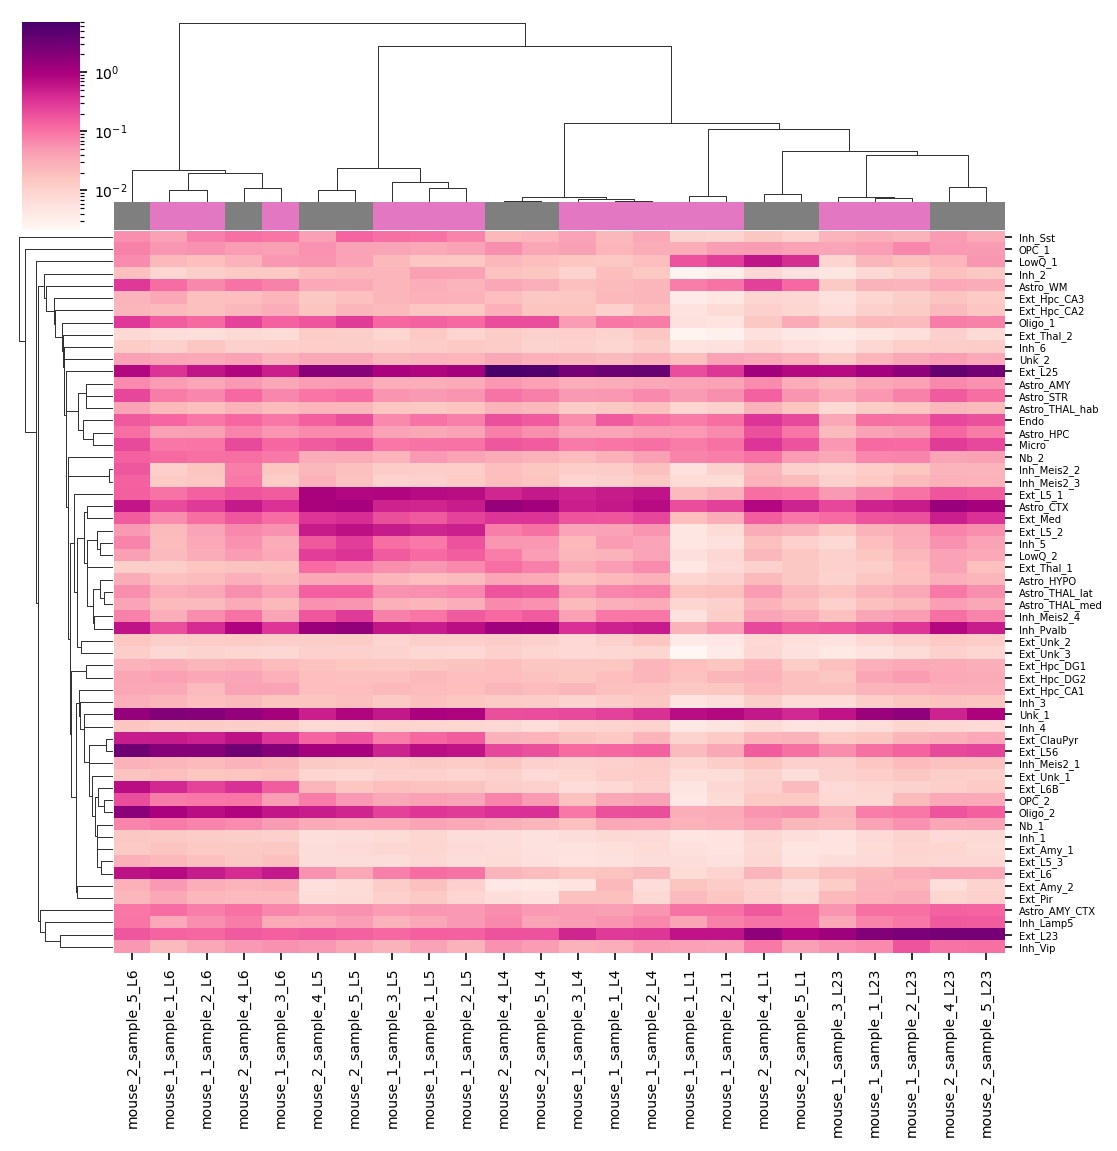

In [14]:
g = sns.clustermap(df, dendrogram_ratio=(.1, .2),
                   figsize=(8, 8), norm=matplotlib.colors.LogNorm(),
                   method='single',
                   col_colors=mouse_colors,
                   metric="correlation",
                   cmap='RdPu')

g.ax_heatmap.set_yticks(np.arange(len(g.dendrogram_row.reordered_ind)) + 0.5)
g.ax_heatmap.set_yticklabels(infer_lay_ST8059051.T.columns[g.dendrogram_row.reordered_ind].values);
g.ax_heatmap.yaxis.set_tick_params(labelsize=5)

plt.savefig('figures/FigS8/FigS8_mouse_colors.pdf', bbox_inches='tight')

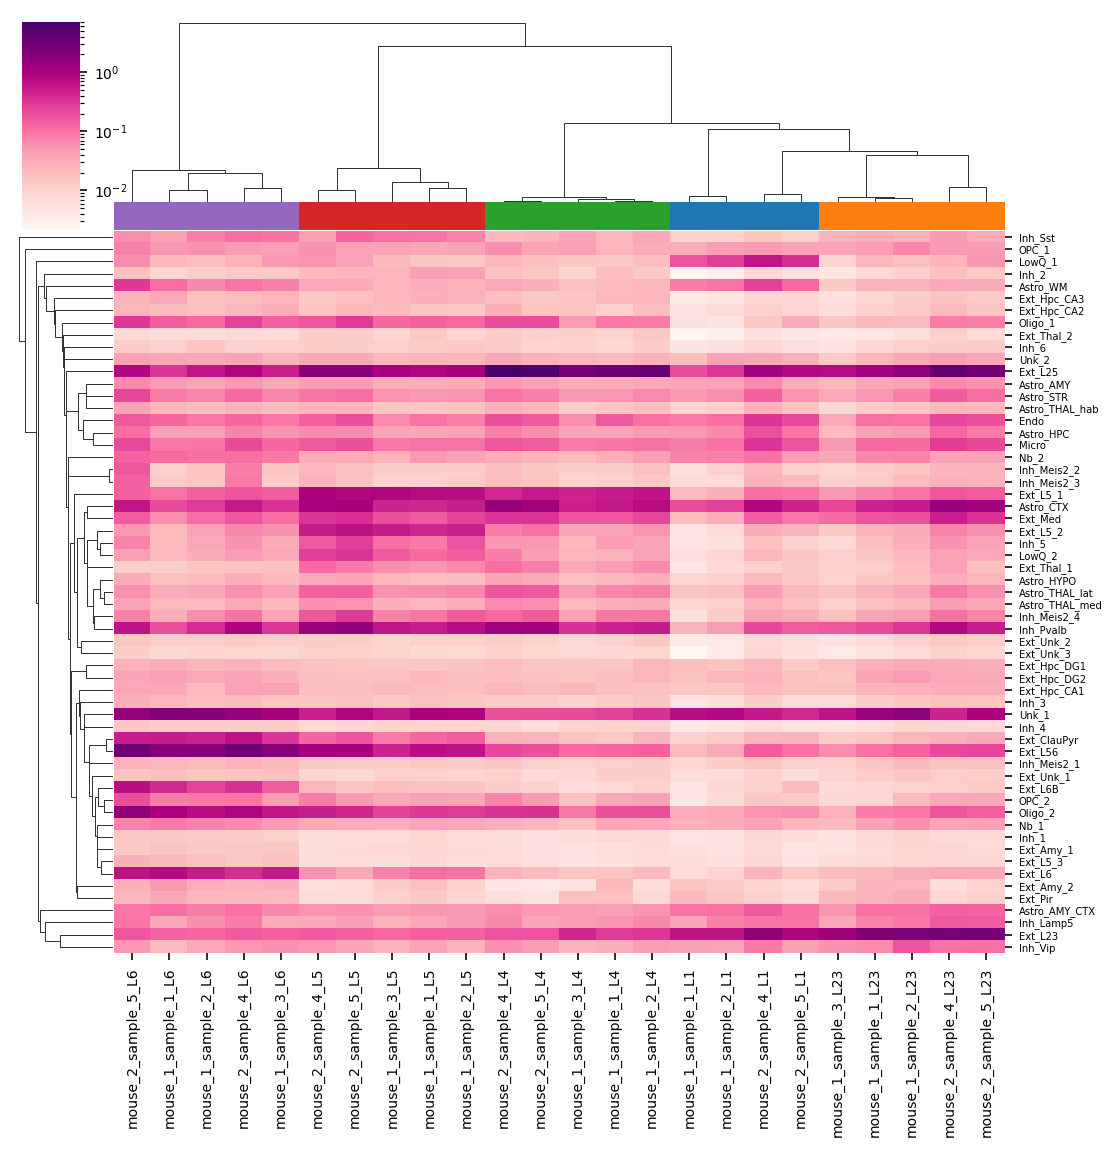

In [15]:
g = sns.clustermap(df, dendrogram_ratio=(.1, .2),
                   figsize=(8, 8), norm=matplotlib.colors.LogNorm(),
                   method='single',
                   col_colors=layer_colors,
                   metric="correlation",
                   cmap='RdPu')

g.ax_heatmap.set_yticks(np.arange(len(g.dendrogram_row.reordered_ind)) + 0.5)
g.ax_heatmap.set_yticklabels(infer_lay_ST8059051.T.columns[g.dendrogram_row.reordered_ind].values);
g.ax_heatmap.yaxis.set_tick_params(labelsize=5)

plt.savefig('figures/FigS8/FigS8_layer_colors.pdf', bbox_inches='tight')

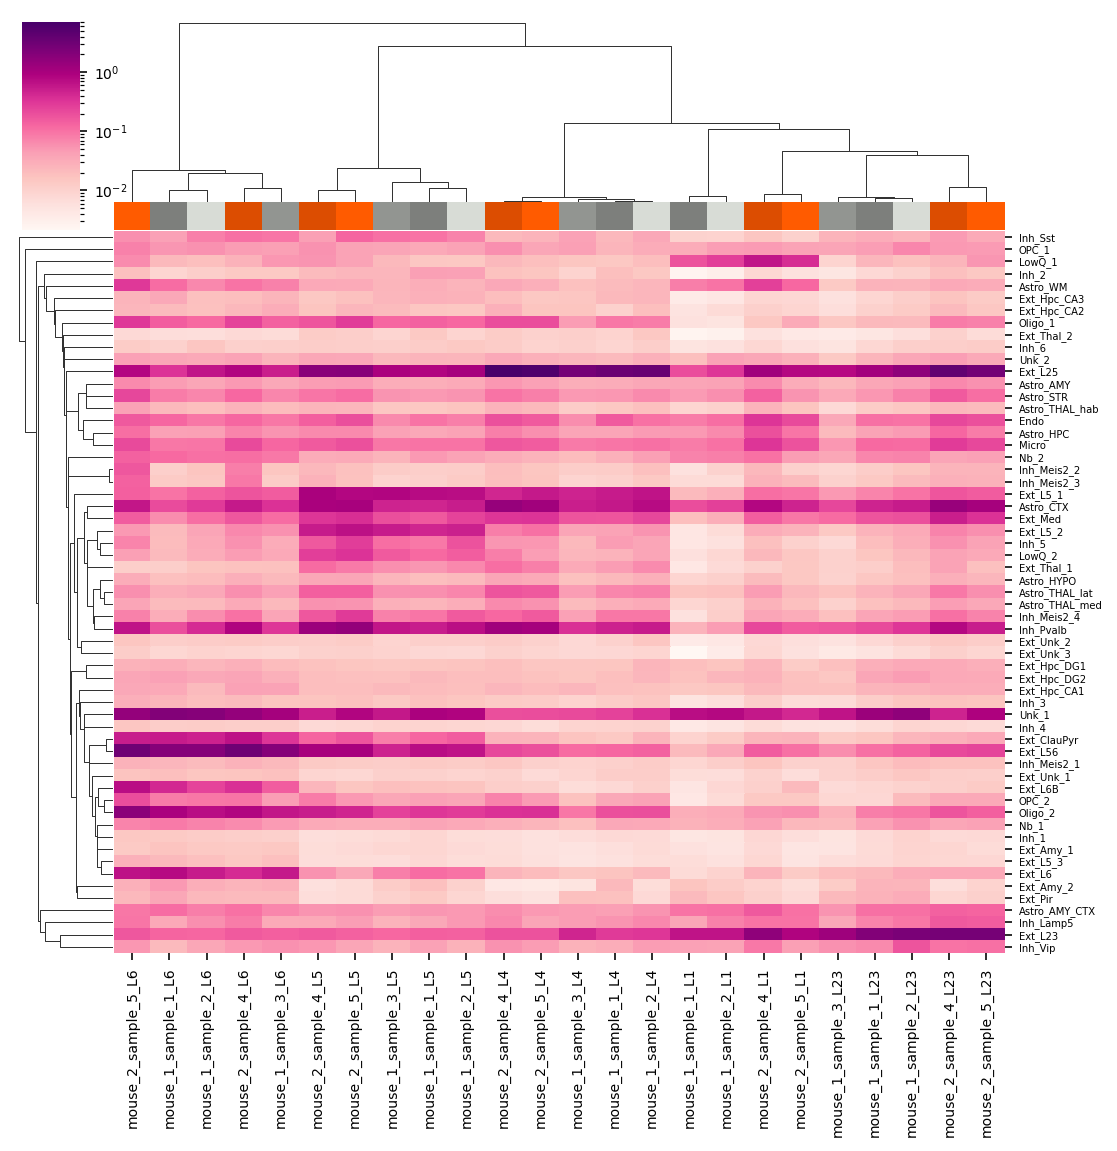

In [16]:
g = sns.clustermap(df, dendrogram_ratio=(.1, .2),
                   figsize=(8, 8), norm=matplotlib.colors.LogNorm(),
                   method='single',
                   col_colors=sample_colors,
                   metric="correlation",
                   cmap='RdPu')

g.ax_heatmap.set_yticks(np.arange(len(g.dendrogram_row.reordered_ind)) + 0.5)
g.ax_heatmap.set_yticklabels(infer_lay_ST8059051.T.columns[g.dendrogram_row.reordered_ind].values);
g.ax_heatmap.yaxis.set_tick_params(labelsize=5)

plt.savefig('figures/FigS8/FigS8_sample_colors.pdf', bbox_inches='tight')

In [17]:
def plot_patch(labels, colors):
    patches = []
    for i in colors:
        patch, = plt.plot([], "s", c=i, markeredgewidth=3, markersize=7.5)
        patches.append(patch)
    plt.legend(patches, labels, frameon=False)

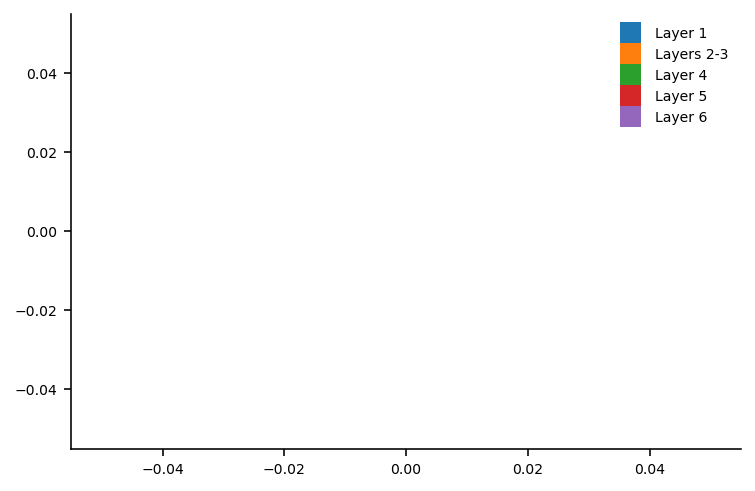

In [18]:
layer_legend_colors = ['C0', 'C1', 'C2', 'C3', 'C4']
layer_legend_labels = ['Layer 1', 'Layers 2-3', 'Layer 4', 'Layer 5', 'Layer 6']
plot_patch(layer_legend_labels, layer_legend_colors)
plt.savefig('figures/FigS8/FigS8_layer_colorbar.pdf', bbox_inches='tight')

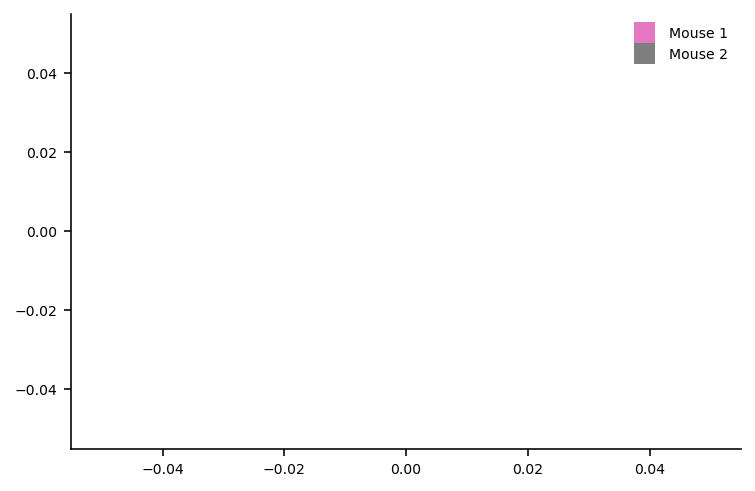

In [19]:
mouse_legend_colors = ['C6', 'C7']
mouse_legend_labels = ['Mouse 1', 'Mouse 2']
plot_patch(mouse_legend_labels, mouse_legend_colors)
plt.savefig('figures/FigS8/FigS8_mouse_colorbar.pdf', bbox_inches='tight')

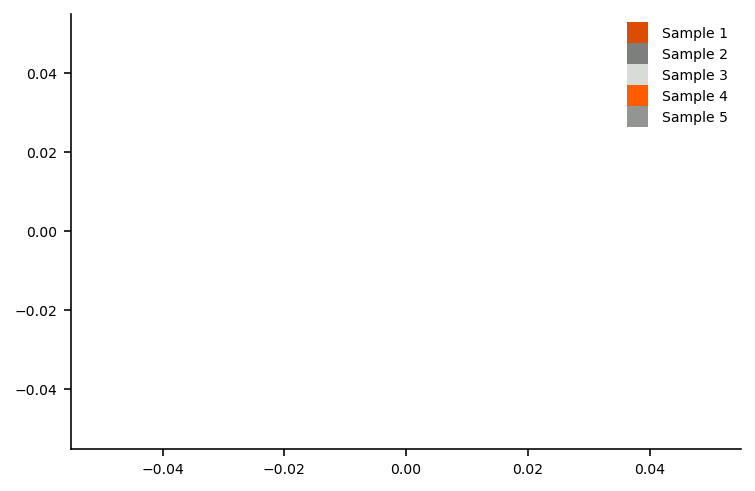

In [20]:
sample_legend_colors = ['xkcd:deep orange', 'xkcd:medium grey', 'xkcd:light grey', 'xkcd:bright orange', 'xkcd:grey']
sample_legend_labels = [f'Sample {i}' for i in range(1, 6)]
plot_patch(sample_legend_labels, sample_legend_colors)
plt.savefig('figures/FigS8/FigS8_sample_colorbar.pdf', bbox_inches='tight')